## Import Libraries

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
import torch
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F

## Import Data

In [81]:
classAmount=3
featureAmount=4

ds = np.lib.DataSource()
fp = ds.open('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')
x = np.genfromtxt(BytesIO(fp.read().encode()), delimiter=',', usecols=range(classAmount+1), max_rows=150)
fp = ds.open('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')
y = np.genfromtxt(BytesIO(fp.read().encode()), delimiter=',', usecols=classAmount+1, dtype=str, max_rows=150)

## LabelEncoder

In [82]:
label_encoder = LabelEncoder()
y_cat = label_encoder.fit_transform(y)
iris_dict=dict(enumerate(label_encoder.classes_))
print(iris_dict)

{0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}


## Split DataSet

In [83]:
mu, std = np.mean(x, axis=0), np.std(x, axis=0)
x=(x - mu) / std
np.random.seed(17)
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
test_size=int(0.2*y.shape[0])
X_test, y_test = x[idx[:test_size]], y_cat[idx[:test_size]]
X_train, y_train = x[idx[test_size:]], y_cat[idx[test_size:]]

## Draw Dataset

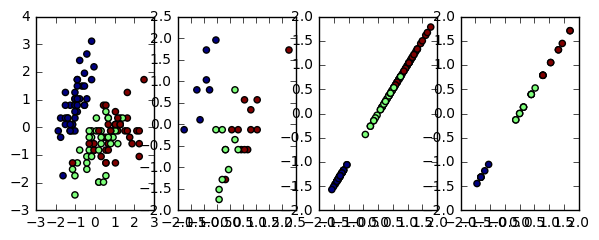

In [84]:
fig, ax = plt.subplots(1, 4, figsize=(7, 2.5))
ax[0].scatter(X_train[:,0], X_train[:,1],c=y_train)
ax[1].scatter(X_test[:,0], X_test[:,1],c=y_test)
ax[2].scatter(X_train[:,2], X_train[:,2],c=y_train)
ax[3].scatter(X_test[:,3], X_test[:,3],c=y_test)
plt.show()

## SoftMaxRegression implementation

In [85]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class SoftMaxRegression():
    def __init__(self, num_features,classAmount):
        self.num_features = num_features
        self.classAmount = classAmount
        
        self.weights = torch.zeros(classAmount, num_features, dtype=torch.float32, device=device)
        self.bias = torch.zeros(classAmount, 1 , dtype=torch.float32, device=device)
        
    def forward(self, x):
        f = torch.mm(self.weights, x) + self.bias
        e=torch.exp(f)
        e/=torch.sum(e)
        return e.view(-1,1)
        
    def backward(self, a, y): 
        gradients =  self._onehot(y)-a
        return gradients 
    
    def _onehot(self,data):
        targets = data.view(-1)
        return torch.eye(self.classAmount)[targets]

    def _logit_cost(self, y, a):
        y_onehot=torch.eye(self.classAmount)[y].view(1,-1)
        return torch.sum(torch.mm(y_onehot*(-1),torch.log(a)))

    def train(self, x, y, num_epochs, learning_rate=0.01):
        costs = []
        
        for e in range(num_epochs):
            
            A=torch.tensor([])
            cost=0
            
            for i in range(x.shape[0]):
                
                # forward propagation
                a = self.forward(x[i].view(-1,1))
                
                # accumulate loss
                cost+= self._logit_cost(y[i], a)    
                A=torch.cat((A, a.view(-1)))
                
            costs.append(cost)
        
            # backward propagation
            A=A.view(-1,classAmount)
            dz = self.backward(A, y)
            dw = torch.mm(x.transpose(0, 1), dz).transpose(0,1)
            db = torch.sum(dz,0)
            
            # update parameters
            self.weights += learning_rate * dw
            self.bias += learning_rate * db.view(-1,1)

        
        costs = np.squeeze(costs)
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('epochs')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

## Train Data

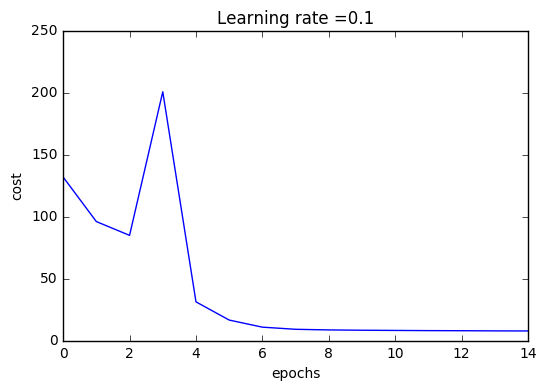


Model parameters:
  Weights: tensor([[-3.8760,  4.2158, -5.2903, -5.1161],
        [ 2.3167, -1.6613,  0.3401, -0.4307],
        [ 1.5593, -2.5545,  4.9502,  5.5468]])
  Bias: tensor([[-0.3322],
        [ 3.7412],
        [-3.4090]])


In [87]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64, device=device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64, device=device)

Sr = SoftMaxRegression(featureAmount,classAmount)
Sr.train(X_train_tensor, y_train_tensor, num_epochs=15, learning_rate=0.1)

print('\nModel parameters:')
print('  Weights: %s' % Sr.weights)
print('  Bias: %s' % Sr.bias)